# Tests

## Imports & defaults

In [1]:
import cartopy.crs as ccrs
import libs.utils
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray

import warnings
warnings.filterwarnings('ignore')

regions = libs.vars.nsidc_regions()
nsidc_all = [
    r for r in regions if r['label'] == 'All'
][0]


def regional(data, nsidc_mask, x, y):
    fig, axs = plt.subplots(
        3, 
        3, 
        figsize=(15, 15),
        subplot_kw={ 
            'projection': ccrs.Stereographic(central_latitude=90.0)
        }
    )
    transform = ccrs.PlateCarree()
    axs = axs.flatten()
    
    for i, region in enumerate(regions[2:]):
        data_masked = data.copy()\
            .sel(time=slice('2015-01-01', '2030-01-01'))\
            .where(np.isin(nsidc_mask.values, region['values']))\
            .mean(dim=('time'), skipna=True)
        
        ax = axs[i]
        ax.coastlines(resolution='110m', linewidth=0.5)
        ax.set_extent([-180, 180, 45, 90], transform)
        gl = ax.gridlines()
        gl.ylocator = matplotlib.ticker.LinearLocator(4)

        # Crop to circle
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = matplotlib.path.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

        data_masked.plot.pcolormesh(
            add_colorbar=False,
            ax=ax,
            levels=21,
            #shading='gouraud', # only enable for Jaspy
            transform=transform,
            x=x, 
            y=y
        )
        ax.set_title(region['label'])

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Regional masks

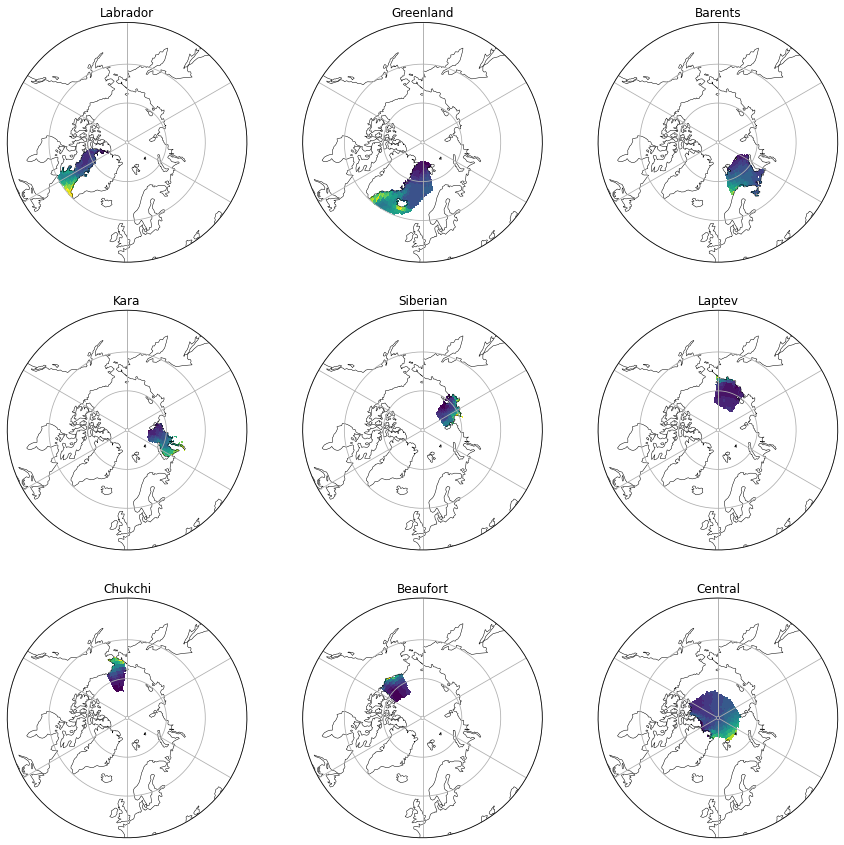

In [2]:
path_nsidc_mask_o = '_data/_cache/NSIDC_Regions_Masks_Ocean_nearest_s2d.nc'
nsidc_mask_o = xarray.open_mfdataset(paths=path_nsidc_mask_o, combine='by_coords').mask

pr = libs.utils.get_data('Amon', 'ssp585', 'UKESM1-0-LL', 'pr', 'r2i1p1f2').pr
pr = pr.where(pr.latitude > 60).where(np.isin(nsidc_mask_o.values, nsidc_all['values']))

regional(pr, nsidc_mask_o, 'longitude', 'latitude')

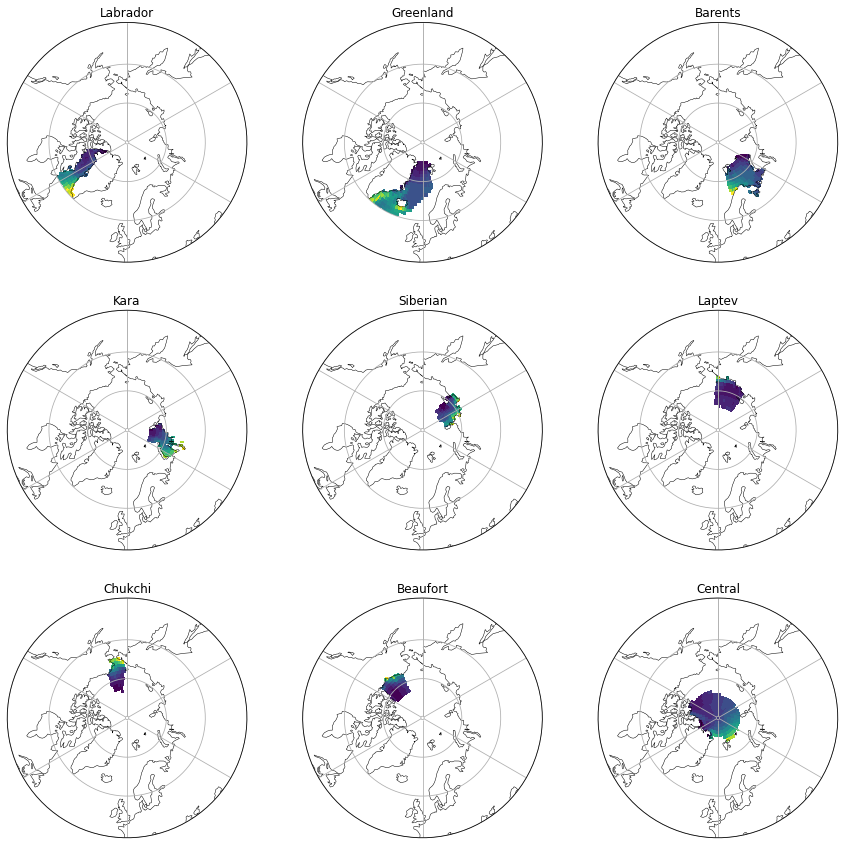

In [3]:
path_nsidc_mask_a = '_data/_cache/NSIDC_Regions_Masks_LatLon_nearest_s2d.nc'
nsidc_mask_a = xarray.open_mfdataset(paths=path_nsidc_mask_a, combine='by_coords').mask
nsidc_mask_a = nsidc_mask_a.roll(x=96, roll_coords=True)

pr_a = libs.utils.get_data('Amon', 'ssp585', 'UKESM1-0-LL', 'pr', 'r2i1p1f2', '_201501-204912').pr
pr_a = pr_a.where(pr_a.lat > 60).where(np.isin(nsidc_mask_a.values, nsidc_all['values']))

regional(pr_a, nsidc_mask_a, 'lon', 'lat')

## Weighted calculations

In [4]:
areacello = libs.utils.get_data('Ofx', 'piControl', 'UKESM1-0-LL', 'areacello', 'r1i1p1f2').areacello
areacello = areacello.fillna(0)
areacella = libs.utils.get_data('fx', 'piControl', 'UKESM1-0-LL', 'areacella', 'r1i1p1f2').areacella

pr_areacello_mean = pr[0, :, :].weighted(areacello).mean(dim=('i', 'j'))
pr_areacella_mean = pr_a[0, :, :].weighted(areacella).mean(dim=('lat', 'lon'))

print(pr_areacello_mean.values, pr_areacella_mean.values)

1.3150069e-05 1.3158711e-05


In [5]:
pr_areacello_sum = pr[0, :, :].weighted(areacello).sum(dim=('i', 'j'))
pr_areacello_multi_sum = (pr[0, :, :] * areacello).sum(dim=('i', 'j'))
pr_areacella_sum = pr_a[0, :, :].weighted(areacella).sum(dim=('lat', 'lon'))
pr_areacella_multi_sum = (pr_a[0, :, :] * areacella).sum(dim=('lat', 'lon'))

print(
    pr_areacello_sum.values, 
    pr_areacello_multi_sum.values, 
    pr_areacella_sum.values,
    pr_areacella_multi_sum.values
)

175950900.0 175950940.0 179277800.0 179277840.0


In [6]:
for r in regions:
    pr_areacello_mean_r = pr[0, :, :]\
        .where(np.isin(nsidc_mask_o.values, r['values']))\
        .weighted(areacello)\
        .mean(dim=('i', 'j'))

    pr_areacella_mean_r = pr_a[0, :, :]\
        .where(np.isin(nsidc_mask_a.values, r['values']))\
        .weighted(areacella)\
        .mean(dim=('lat', 'lon'))
    
    print(r['label'], 'mean:')
    print('-> latlon:', pr_areacella_mean_r.values)
    print('-> regridded ocean:', pr_areacello_mean_r.values)
    print('-> diff:', 100 - (pr_areacello_mean_r.values / pr_areacella_mean_r.values * 100), '%')

All mean:
-> latlon: 1.3158711e-05
-> regridded ocean: 1.3150069e-05
-> diff: 0.06567239761352539 %
Arctic Ocean mean:
-> latlon: 7.1978725e-06
-> regridded ocean: 7.2334906e-06
-> diff: -0.49483776092529297 %
Labrador mean:
-> latlon: 1.2332609e-05
-> regridded ocean: 1.2193632e-05
-> diff: 1.1269092559814453 %
Greenland mean:
-> latlon: 3.4689518e-05
-> regridded ocean: 3.4614142e-05
-> diff: 0.21728277206420898 %
Barents mean:
-> latlon: 2.0977286e-05
-> regridded ocean: 2.1003807e-05
-> diff: -0.12642145156860352 %
Kara mean:
-> latlon: 5.761199e-06
-> regridded ocean: 5.461421e-06
-> diff: 5.2033960819244385 %
Siberian mean:
-> latlon: 3.665125e-06
-> regridded ocean: 3.6758536e-06
-> diff: -0.29271841049194336 %
Laptev mean:
-> latlon: 2.7310994e-06
-> regridded ocean: 2.7108686e-06
-> diff: 0.7407546043395996 %
Chukchi mean:
-> latlon: 1.0047299e-05
-> regridded ocean: 1.0080047e-05
-> diff: -0.3259420394897461 %
Beaufort mean:
-> latlon: 4.6014916e-06
-> regridded ocean: 4.5327